In [29]:
import numpy as np
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
from pathlib import Path

DATA_DIR = Path('../backend/api/data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'
INFOBUSES = RAW_DATA / 'buses'

orig_df = pd.read_excel(RAW_DATA / 'paraderos-2018-04-07.xlsx', dtype={'Orden': int, 'Servicio TS': str, 'Variante': str, 'Sentido Servicio': str})

print(orig_df.columns)
print(len(orig_df.columns), 'columnas')
orig_df.head()

Index(['Orden', 'Servicio TS', 'Servicio Usuario', 'Sentido Servicio',
       'Varian-te', 'UN', 'Código paradero TS', 'Código  paradero Usuario',
       'Comuna', 'Eje', 'Desde ( Cruce 1)', 'Hacia ( Cruce 2)', 'x', 'y',
       'Nombre Paradero', 'Zonas Pagas (horario de operación)',
       'Paradas con Excepciones'],
      dtype='object')
17 columnas


,Orden,Servicio TS,Servicio Usuario,Sentido Servicio,Varian-te,UN,Código paradero TS,Código paradero Usuario,Comuna,Eje,Desde ( Cruce 1),Hacia ( Cruce 2),x,y,Nombre Paradero,Zonas Pagas (horario de operación),Paradas con Excepciones
0,1,101,101,I,NaN,U1,T-4-25-OP-5,PB1,RECOLETA,VENEZUELA,LAS CANTERAS,BOLIVIA,349064.95,6302684.85,Venezuela / esq. Bolivia,NaN,NaN
1,2,101,101,I,NaN,U1,T-4-25-OP-10,PB2,RECOLETA,VENEZUELA,M. DE MONTEPIO,H. DE LA CONCEPCION,348731.7,6302912.63,Venezuela / esq. H. de La Concepción,NaN,NaN
2,3,101,101,I,NaN,U1,T-4-24-OP-5,PB3,RECOLETA,REINA DE CHILE,AV. LAS TORRES,EL SALTO,348441.67,6303045,Reina de Chile / esq. Avenida El Salto,NaN,NaN
3,4,101,101,I,NaN,U1,T-4-23-OP-5,PB4,RECOLETA,PEDRO DONOSO,SAN JOSÉ,SANTA ANA,348136.5,6303261.23,Pedro Donoso / esq. Santa Ana,NaN,NaN
4,5,101,101,I,NaN,U1,T-4-23-OP-10,PB5,RECOLETA,PEDRO DONOSO,MARÍA EUGENIA,MARÍA DEL PILAR,347778.47,6303354.55,Pedro Donoso / esq. María del Pilar,NaN,NaN


# Preprocesamiento

In [30]:
#    'Orden', 'Servicio TS', 'Servicio Usuario', 'Sentido Servicio',
#    'Varian-te', 'UN', 'Código paradero TS', 'Código  paradero Usuario',
#    'Comuna', 'Eje', 'Desde ( Cruce 1)', 'Hacia ( Cruce 2)', 'x', 'y',
#    'Nombre Paradero', 'Zonas Pagas (horario de operación)',
#    'Paradas con Excepciones'
columnas_utiles = [
    "Orden",
    "Servicio TS",
    "Variante",
    "x",
    "y",
    "Sentido Servicio",
    "Operación con Zona Paga",
    "Código paradero TS",
    "Paradas con Excepciones",
    'Zonas Pagas'
]
# nombres columnas
df = orig_df.rename(columns={'Varian-te': 'Variante', 'Zonas Pagas (horario de operación)': 'Zonas Pagas'})
df = df[
    df.columns.intersection(
        columnas_utiles
    )
]

# eliminamos paradas con datos faltantes
defined_x = df['x'] != 'POR DEFINIR'
defined_y = df['y'] != 'POR DEFINIR'
defined_code = df['Código paradero TS'] != 'POR DEFINIR'
df = df[defined_code & defined_y & defined_x]

defined_count = (defined_code & defined_y & defined_x).value_counts()
if(len(defined_count) == 1 and defined_count.iloc[0] == len(df)):
    print('Todos las paradas están bien definidas')

# arreglar mayúsculas
df['Sentido Servicio'] = df['Sentido Servicio'].apply(lambda x: x if x != 'ida' else 'Ida')

# llenamos los vacíos con un string vacío
df['Variante'] = df['Variante'].fillna('')

df.head()

,Orden,Servicio TS,Sentido Servicio,Variante,Código paradero TS,x,y,Zonas Pagas,Paradas con Excepciones
0,1,101,I,,T-4-25-OP-5,349064.95,6302684.85,NaN,NaN
1,2,101,I,,T-4-25-OP-10,348731.7,6302912.63,NaN,NaN
2,3,101,I,,T-4-24-OP-5,348441.67,6303045,NaN,NaN
3,4,101,I,,T-4-23-OP-5,348136.5,6303261.23,NaN,NaN
4,5,101,I,,T-4-23-OP-10,347778.47,6303354.55,NaN,NaN


# Exploración de las columnas

## Revisando: Servicio TS
Esto vendría siendo el código del recorrido/servicio cuya ruta está descrita por los distintos puntos

In [16]:
# cantidad de recorridos
servicio_count = df['Servicio TS'].value_counts()

print("Existen un total de {} recorridos descritos".format(len(df['Servicio TS'].value_counts())))
print('Estos van entre {min} y {max} paradas por recorrido'.format(min=servicio_count.iloc[-1], max=servicio_count.iloc[0]))

Existen un total de 379 recorridos descritos
Estos van entre 2 y 605 paradas por recorrido


## Revisando: Variantes
Distintos posibles recorridos dependiendo de cosas como el horario

**no logro encontrar las definiciones de estas variantes**

In [17]:
variante_counts = df['Variante'].value_counts()
print(variante_counts)
print('un total de', variante_counts.sum(), 'paradas de las cuales', variante_counts[1:].sum(), 'paradas que difieren del recorrido original')

Variante
        35045
PRN      3529
PM       3150
PT       1065
N         847
TNOC      123
PMPT       62
Name: count, dtype: int64
un total de 43821 paradas de las cuales 8776 paradas que difieren del recorrido original


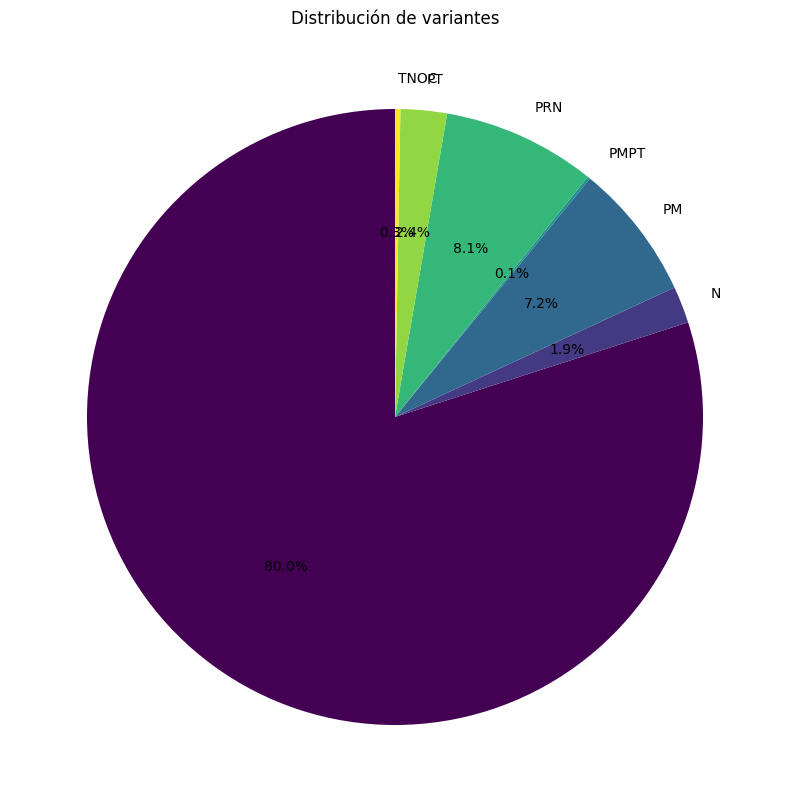

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
variante_counts.sort_index().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribución de variantes')
plt.ylabel('')  # Quitar la etiqueta del eje y
plt.show()


In [19]:
sentido_counts = df['Sentido Servicio'].value_counts()
missing_sentido = len(df) - sentido_counts.sum()
if(missing_sentido == 0):
    print('Todos las {count} paradas indican el sentido del recorrido'.format(count=len(df)))
else:
    print('Se encontraron', missing_sentido, 'paradas que no indican el sentido')
print('La repartición es:')
for i in sentido_counts.index:
    print(i, ': {porcentaje}%'.format(porcentaje=str(sentido_counts[i] / len(df))[:6]))

print()
print('La cuenta total es la siguiente')
print(sentido_counts)

Todos las 43821 paradas indican el sentido del recorrido
La repartición es:
I : 0.5134%
R : 0.4865%

La cuenta total es la siguiente
Sentido Servicio
I    22498
R    21323
Name: count, dtype: int64


In [20]:
def joinVarianteSentido(row):
    v = row['Variante']
    s = row['Sentido Servicio']
    return s + '-' + v if v != '' else s

print('Posibles combinaciones sentido-variación')
sent_var = df.apply(joinVarianteSentido, axis=1)
sent_var.value_counts()

Posibles combinaciones sentido-variación


I         18144
R         16901
I-PM       1871
R-PRN      1783
I-PRN      1746
R-PM       1279
R-PT        861
I-N         428
R-N         419
I-PT        204
I-TNOC       70
R-TNOC       53
I-PMPT       35
R-PMPT       27
Name: count, dtype: int64

In [21]:
df['Orden'].value_counts().sort_index()

Orden
1      873
2      903
3      901
4      896
5      902
      ... 
134      2
135      1
136      2
137      1
138      1
Name: count, Length: 138, dtype: int64

## Revisando: Operación con Zona Paga	

In [32]:
zona_paga_count = df['Zonas Pagas'].value_counts()
zona_paga_count

Zonas Pagas
LAB(16:00-21:00)               82
LAB(6:30-10:00)                60
LAB(6:00-10:00)                49
LAB(6:00-8:30)                 44
LAB(17:00-21:00)               44
                               ..
18:00 - 21:00                   2
LAB(6:30-9:30)(16:30-21:00)     2
07:00 - 10:00                   1
06:30 - 09:30                   1
06:00 - 23:00                   1
Name: count, Length: 88, dtype: int64

## Revisando: Paradas con Excepciones

In [33]:
excepciones_count = df['Paradas con Excepciones'].value_counts()

print('Hay un total de {suma} paradas con excepciones, de las cuales existen {lenght} excepciones distintas'.format(suma=excepciones_count.sum(), lenght=len(excepciones_count)))

Hay un total de 1676 paradas con excepciones, de las cuales existen 94 excepciones distintas


In [34]:
posibles_ex = excepciones_count.index
print('Estas serían las siguientes:')

mask_utiliza = posibles_ex.str.contains("Utiliza")
utiliza_count = len(posibles_ex[mask_utiliza])
print('{count} indican que utilizan el paradero en un determinado horario'.format(count = utiliza_count))
mask_circula = posibles_ex.str.contains("circula")
circula_count = len(posibles_ex[mask_circula])
print('{count} indican que circula por otra calle en un determinado horario'.format(count = circula_count))
print('Eso consideraría {suma} del total de {total} excepciones'.format(suma=utiliza_count + circula_count, total=len(posibles_ex)))
print()
print('Las demás excepciones son las siguientes:')
for i in posibles_ex[~mask_circula & ~mask_utiliza]:
    print(i)

Estas serían las siguientes:
29 indican que utilizan el paradero en un determinado horario
57 indican que circula por otra calle en un determinado horario
Eso consideraría 86 del total de 94 excepciones

Las demás excepciones son las siguientes:
Entre 06:30 a 09:30 y 17:30 a 21:30 no se detiene en esta parada
Entre 16:45 y 20:10 no se detiene en esta parada
No cuenta con servicio nocturno en esta parada
Entre 06:30 y 09:30 no se detiene en esta parada
Entre 16:00 y 20:00 no se detiene en esta parada. Circula por Calet. Vespucio
Entre 16:00 y 20:00 no entra al centro cívico de Quilicura. Circula por Calet. Vespucio
Entre 05:30 y 09:30 no se detiene en esta parada
Entre 7:30 y 10:00 no se detiene en esta parada


## Revisando el caso del servicio con más paraderos

Variante
      242
PM    242
PT    121
Name: count, dtype: int64


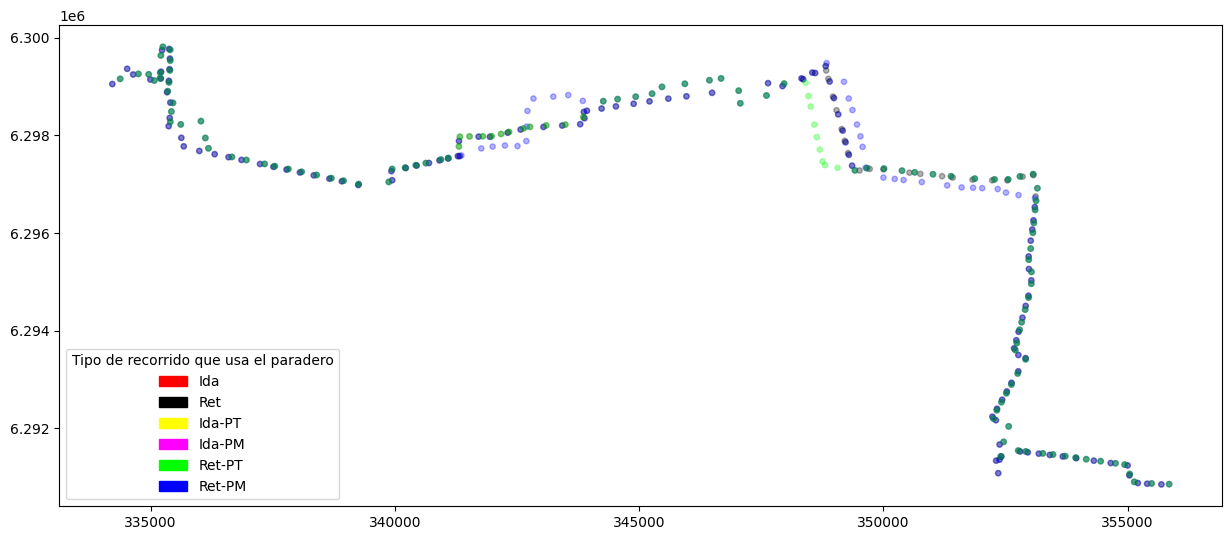

In [35]:
from shapely import Point

servicio_max = servicio_count.index[0]

paraderos_max = df[df['Servicio TS'] == servicio_max]


print(paraderos_max['Variante'].value_counts())

def getColor(row):
    r = 1 if row['Sentido Servicio'] == 'Ida' else 0
    g = 1 if row['Variante'] == 'PT' else 0
    b = 1 if row['Variante'] == 'PM' else 0

    return (r, g, b)
geom = paraderos_max.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_max = gpd.GeoDataFrame(data=paraderos_max, geometry=geom, crs='epsg:5361')
colores_paraderos = geo_max.apply(getColor, axis=1)


import matplotlib.pyplot as plt
from matplotlib.patches import Patch 

fig, ax = plt.subplots(figsize=(15,15))
geo_max.plot(ax=ax, c=colores_paraderos, markersize=15, alpha=0.3)

labels = ['Ida', 'Ret', 'Ida-PT', 'Ida-PM', 'Ret-PT', 'Ret-PM']
colors = [(1, 0, 0), (0, 0, 0), (1, 1, 0), (1, 0, 1), (0, 1, 0), (0, 0, 1)]
patches = [Patch(color=color, label=label) for color, label in zip(colors, labels)]

ax.legend(handles=patches, title='Tipo de recorrido que usa el paradero')


In [38]:
geo2 = geo_max.to_crs('EPSG:9152')

uniques = geo2.drop_duplicates(subset=['Código paradero TS'], keep='first')

uniques

,Orden,Servicio TS,Sentido Servicio,Variante,Código paradero TS,x,y,Zonas Pagas,Paradas con Excepciones,geometry
30882,1,514,I,,L-10-55-13-OP,334217.99,6299049.82,NaN,NaN,POINT (-70.78336 -33.43514)
30884,3,514,I,,L-10-31-30-PO,334522.23,6299361.81,NaN,NaN,POINT (-70.78003 -33.43237)
30885,4,514,I,,L-10-55-5-PO,334644.32,6299245.56,NaN,NaN,POINT (-70.77874 -33.43344)
30886,5,514,I,,L-10-54-5-NS,334996.41,6299142.27,NaN,NaN,POINT (-70.77497 -33.43443)
30888,7,514,I,,L-10-37-35-SN,335212,6299163.47,NaN,NaN,POINT (-70.77265 -33.43427)
...,...,...,...,...,...,...,...,...,...,...
31425,56,514,R,PT,T-14-132-SN-5,348639.18,6297963.3,NaN,Utiliza esta parada sólo entre 17:00 y 21:00,POINT (-70.62847 -33.44707)
31426,57,514,R,PT,T-14-132-SN-10,348586.35,6298219.35,NaN,Utiliza esta parada sólo entre 17:00 y 21:00,POINT (-70.62899 -33.44475)
31427,58,514,R,PT,T-14-132-SN-15,348513.21,6298590.76,NaN,Utiliza esta parada sólo entre 17:00 y 21:00,POINT (-70.62972 -33.44139)
31428,59,514,R,PT,T-14-132-SN-20,348465.88,6298803.97,NaN,Utiliza esta parada sólo entre 17:00 y 21:00,POINT (-70.63019 -33.43947)


In [41]:
bus_stops = df.drop_duplicates(keep='first', subset=['Código paradero TS'])

# well_place = defined[defined['x'].apply(float) > 100]

geom =  bus_stops.apply(lambda row: Point(row['x'], row['y']), axis=1)
geopd = gpd.GeoDataFrame(data=bus_stops.drop(columns=[
    'x', 
    'y', 
    'Orden', 
    'Sentido Servicio', 
    'Variante', 
    'Servicio TS',
    'Zonas Pagas',
    'Paradas con Excepciones'
    ]), geometry=geom, crs='epsg:5361')
geopd['Código paradero TS'].value_counts()

Código paradero TS
T-4-25-OP-5      1
L-32-18-60-PO    1
L-19-3-5-SN      1
L-19-16-30-OP    1
L-19-16-20-OP    1
                ..
L-30-25-40-OP    1
L-30-25-30-OP    1
L-30-25-20-OP    1
L-30-62-31-PO    1
T-31-253-NS-5    1
Name: count, Length: 11302, dtype: int64

<Axes: >

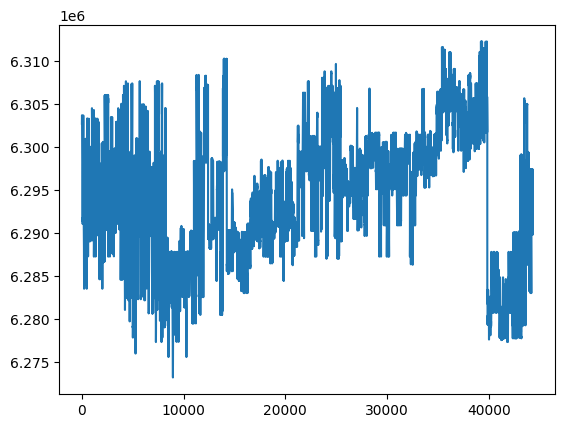

In [42]:
# defined['x'].astype(float).plot()
df['y'].astype(float).plot()

<Axes: >

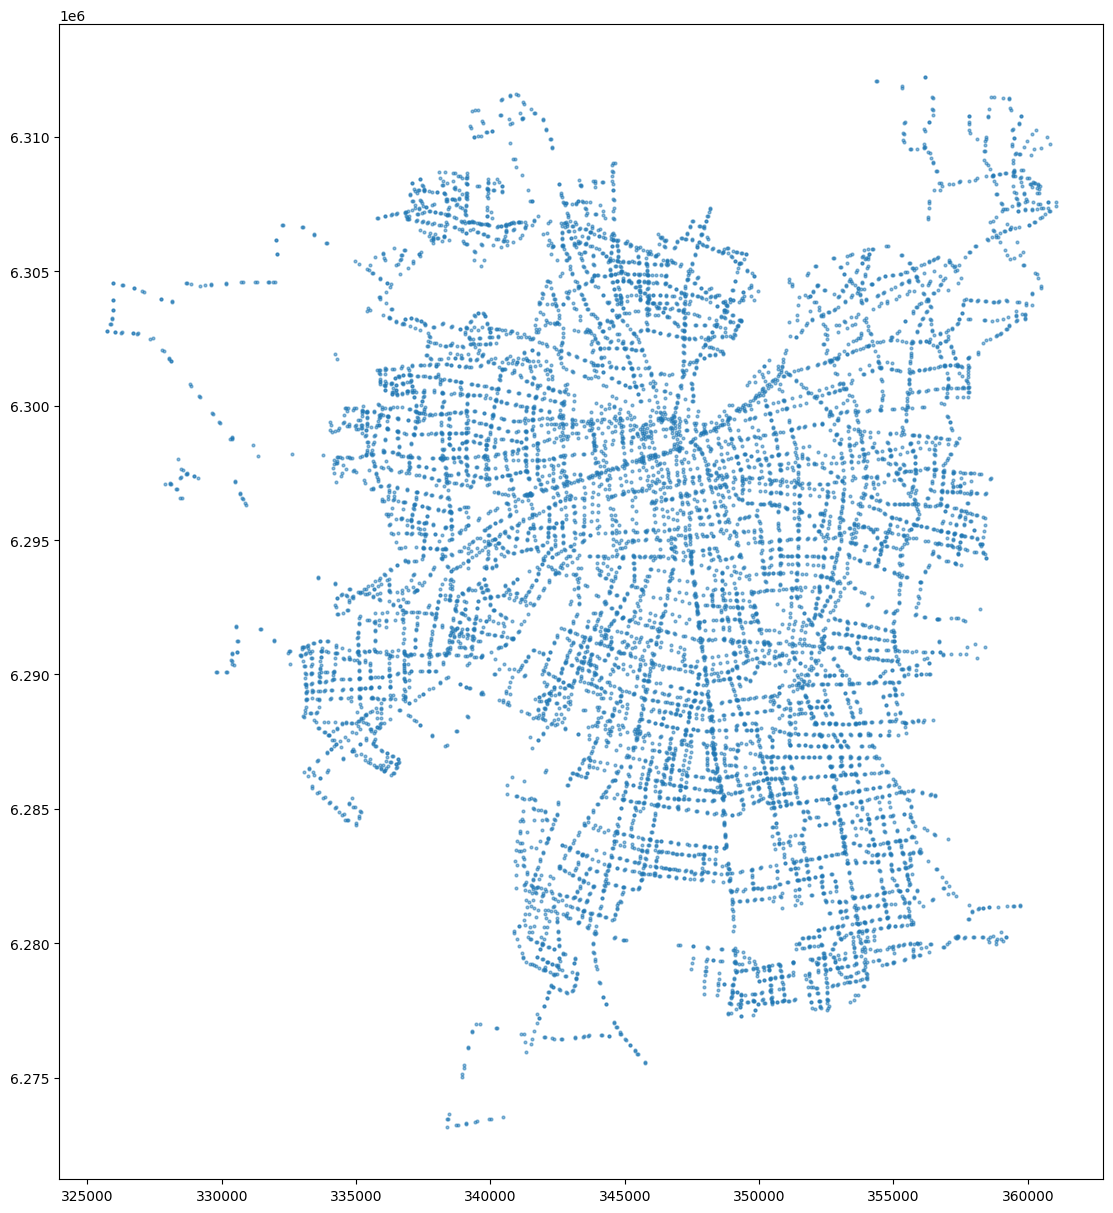

In [43]:
geopd.plot(alpha=0.5, markersize=4, figsize=(15, 15))

<Axes: >

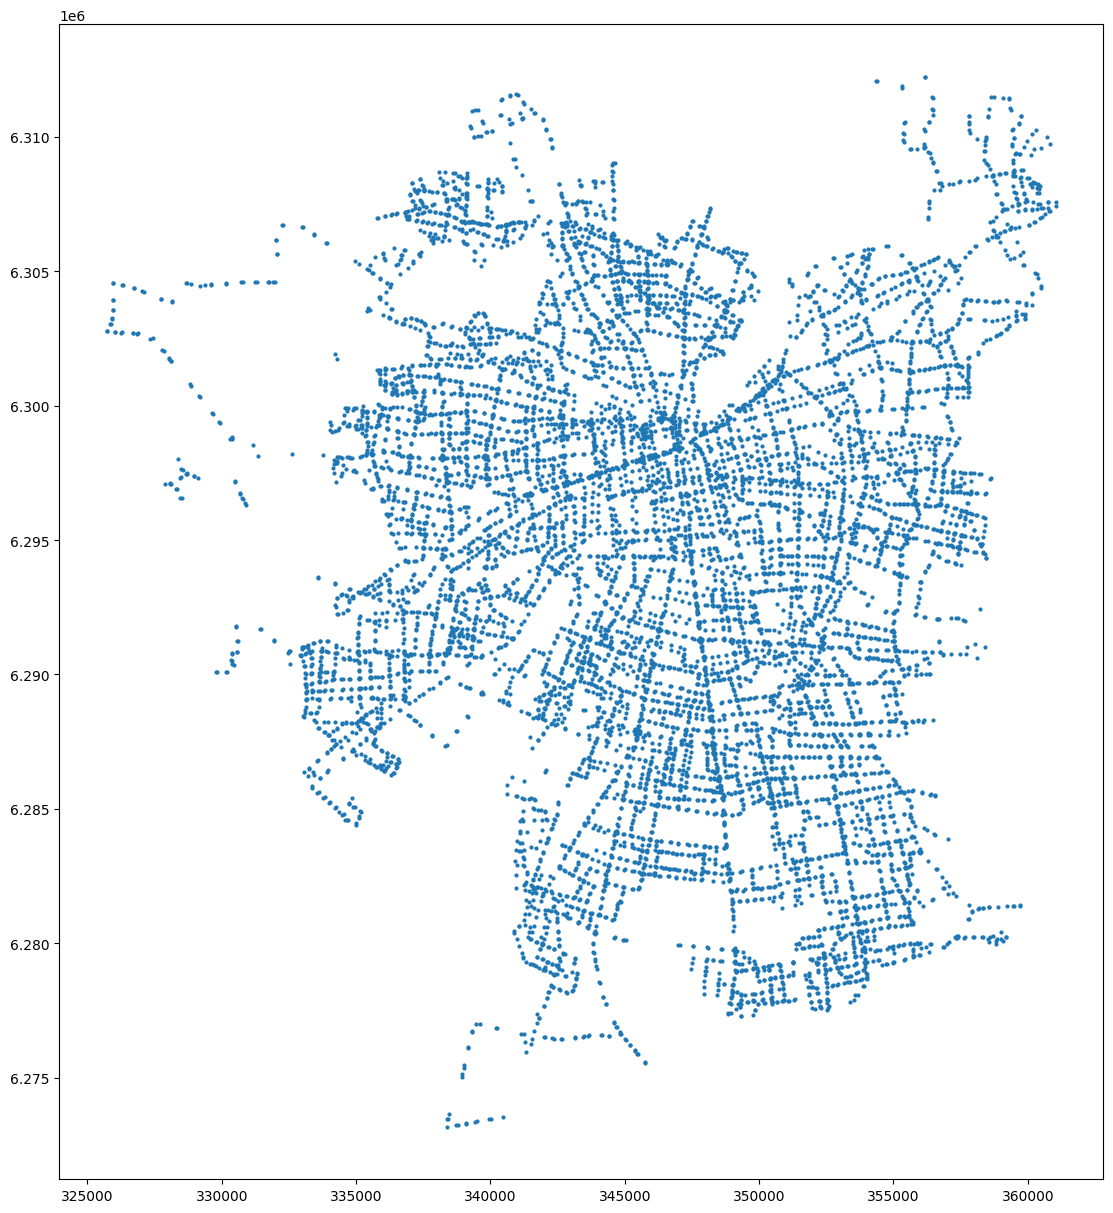

In [44]:
geopd.drop_duplicates(subset=['Código paradero TS']).plot(alpha=1, markersize=4, figsize=(15, 15))#color='violet')

In [45]:
geopd.drop_duplicates(subset=['geometry'])

,Código paradero TS,geometry
0,T-4-25-OP-5,POINT (349064.950 6302684.850)
1,T-4-25-OP-10,POINT (348731.700 6302912.630)
2,T-4-24-OP-5,POINT (348441.670 6303045.000)
3,T-4-23-OP-5,POINT (348136.500 6303261.230)
4,T-4-23-OP-10,POINT (347778.470 6303354.550)
...,...,...
44271,L-18-10-10-PO,POINT (349449.810 6295308.070)
44276,L-31-18-15-NS,POINT (350074.600 6294538.310)
44277,L-31-18-25-NS,POINT (350095.920 6294278.990)
44278,L-31-18-30-NS,POINT (350116.200 6294014.670)
